# BNN_v1: original BNN

In [13]:
import numpy as np

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchbnn as bnn

import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
ck_dir=f'./checkpoint/OOD/'
result_dir=f'result/OOD/BNN_v3'
ck_path=os.path.join(ck_dir, f'bnn_v3.pt')

os.makedirs(ck_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

## 1. Load Mnist

In [15]:
def getSets(filteredClass = None, removeFiltered = True) :
	"""
	Return a torch dataset. If removeFiltered = True, then return all rest class. Or it only returns one class.
	"""
	
	train = torchvision.datasets.MNIST('./data/', train=True, download=True,
								transform=torchvision.transforms.Compose([
										torchvision.transforms.ToTensor(),
										torchvision.transforms.Normalize((0.1307,), (0.3081,))
								]))

	test = torchvision.datasets.MNIST('./data/', train=False, download=True,
								transform=torchvision.transforms.Compose([
										torchvision.transforms.ToTensor(),
										torchvision.transforms.Normalize((0.1307,), (0.3081,))
								]))
	
	if filteredClass is not None :
		
		train_loader = torch.utils.data.DataLoader(train, batch_size=len(train))
		train_labels = next(iter(train_loader))[1].squeeze()
		test_loader = torch.utils.data.DataLoader(test, batch_size=len(test))
		test_labels = next(iter(test_loader))[1].squeeze()
		
		if removeFiltered : 
			trainIndices = torch.nonzero(train_labels != filteredClass).squeeze()
			testIndices = torch.nonzero(test_labels != filteredClass).squeeze()
		else :
			trainIndices = torch.nonzero(train_labels == filteredClass).squeeze()
			testIndices = torch.nonzero(test_labels == filteredClass).squeeze()
		
		train = torch.utils.data.Subset(train, trainIndices)
		test = torch.utils.data.Subset(test, testIndices)
	
	return train, test

In [16]:
train, test = getSets(filteredClass=4)
batch_size=64

train_loader = DataLoader(train, batch_size=64)
test_loader = DataLoader(test, batch_size=64)

## 2. Define Model

In [17]:
class BayesianMnistNet(nn.Module):
    def __init__(self):
        super(BayesianMnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = bnn.BayesLinear(prior_mu=0., prior_sigma=.1, in_features=128, out_features=10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def bnn_inference(self, x, num_samples=32):
        outputs = []
        for _ in range(num_samples):
            output = self.forward(x)
            outputs.append(output.unsqueeze(0))
        outputs = torch.cat(outputs, dim=0)
        output_mean = outputs.mean(dim=0)
        output_std = outputs.std(dim=0)
        return output_mean, output_std

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BayesianMnistNet().to(device)
ce = nn.CrossEntropyLoss()
kl = bnn.BKLLoss(reduction='sum', last_layer_only=False)
kl_weight = .01
n_epoch = 3

optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 3. Train Model

In [19]:
ce_losses = []
kl_losses = []
losses = []
epoch_losses = []

for epoch in range(n_epoch):
    model.train()
    epoch_loss = 0.
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{n_epoch}', leave=True) as pbar:
            for batch_id, sampl in enumerate(train_loader):
                    imgs, labels = sampl
                    imgs, labels = imgs.to(device), labels.to(device)

                    pred = model(imgs)
                    # print('pred', pred[0])
                    # print('labels', labels[0])
                    # input()
                    ce_loss = ce(pred, labels)
                    kl_loss = kl(model)
                    total_loss = ce_loss + kl_weight*kl_loss
                    
                    ce_loss_cpu = ce_loss.detach().cpu().item()
                    kl_loss_cpu = kl_loss.detach().cpu().item()
                    total_loss_cpu = total_loss.detach().cpu().item()
                    kl_losses.append(kl_loss_cpu)
                    ce_losses.append(ce_loss_cpu)
                    losses.append(total_loss_cpu)         

                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()

                    epoch_loss += total_loss.item()
                    pbar.set_postfix({'kl Loss': f'{kl_loss.detach().cpu().item():.4f}',
									  'Total Loss': f'{total_loss.detach().cpu().item()/batch_size:.4f}'})
                    pbar.update(1)
					
    print(f'Epoch {epoch+1}/{n_epoch} - Epoch Loss: {epoch_loss/len(train_loader)}')
    epoch_losses.append(epoch_loss/len(train_loader))


torch.save(model.state_dict(), ck_path)

Epoch 1/3: 100%|██████████| 847/847 [00:16<00:00, 52.29it/s, kl Loss=43.9355, Total Loss=0.0090]


Epoch 1/3 - Epoch Loss: 1.1278550709645048


Epoch 2/3: 100%|██████████| 847/847 [00:20<00:00, 42.09it/s, kl Loss=41.0278, Total Loss=0.0099]


Epoch 2/3 - Epoch Loss: 0.6738746364324968


Epoch 3/3: 100%|██████████| 847/847 [00:20<00:00, 40.53it/s, kl Loss=41.3546, Total Loss=0.0140]


Epoch 3/3 - Epoch Loss: 0.6018677985442994


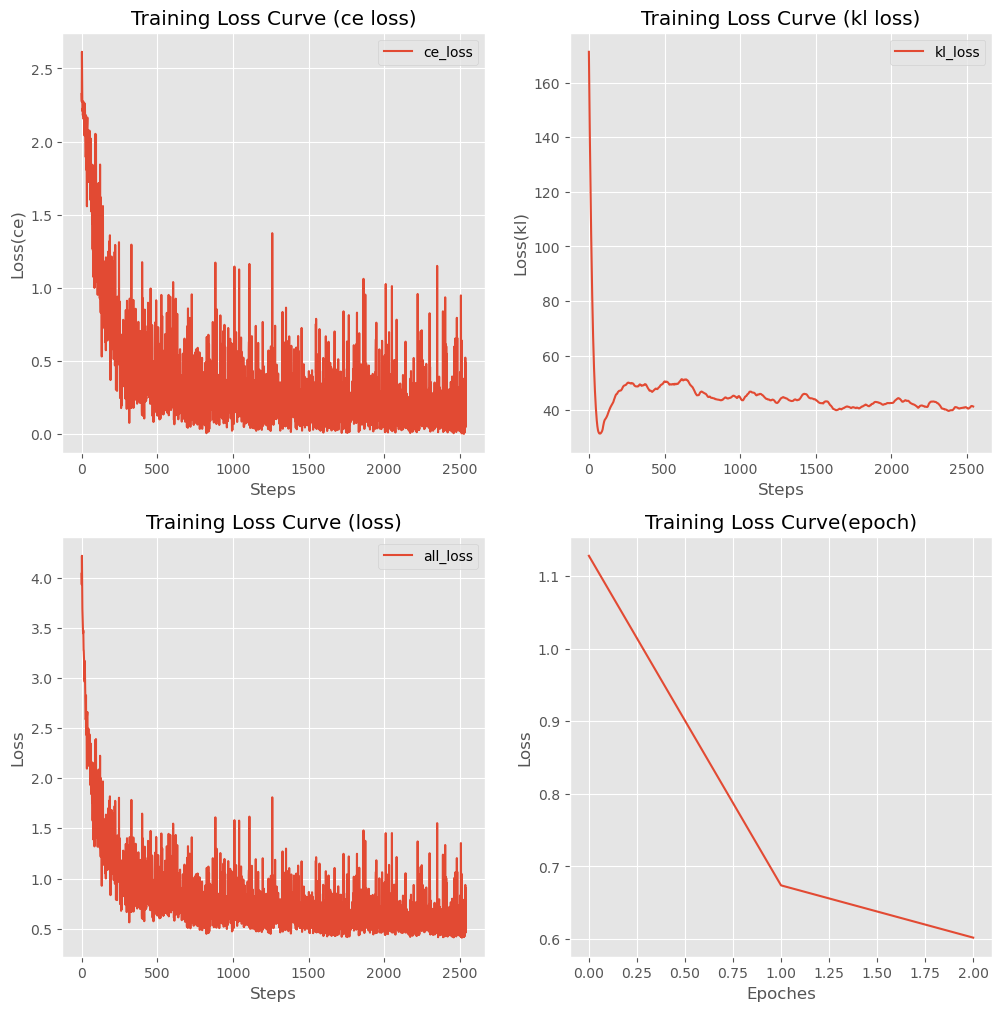

In [20]:
# Plotting after training
plt.style.use('ggplot')
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(ce_losses, label='ce_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(ce)')
plt.legend()
plt.title('Training Loss Curve (ce loss)')

plt.subplot(2,2,2)
plt.plot(kl_losses, label='kl_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(kl)')
plt.legend()
plt.title('Training Loss Curve (kl loss)')

plt.subplot(2,2,3)
plt.plot(losses, label='all_loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve (loss)')

plt.subplot(2,2,4)
plt.plot(epoch_losses)
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.title('Training Loss Curve(epoch)')
plt.savefig(os.path.join(result_dir,'Training Curve(epoch).png'))
plt.show()

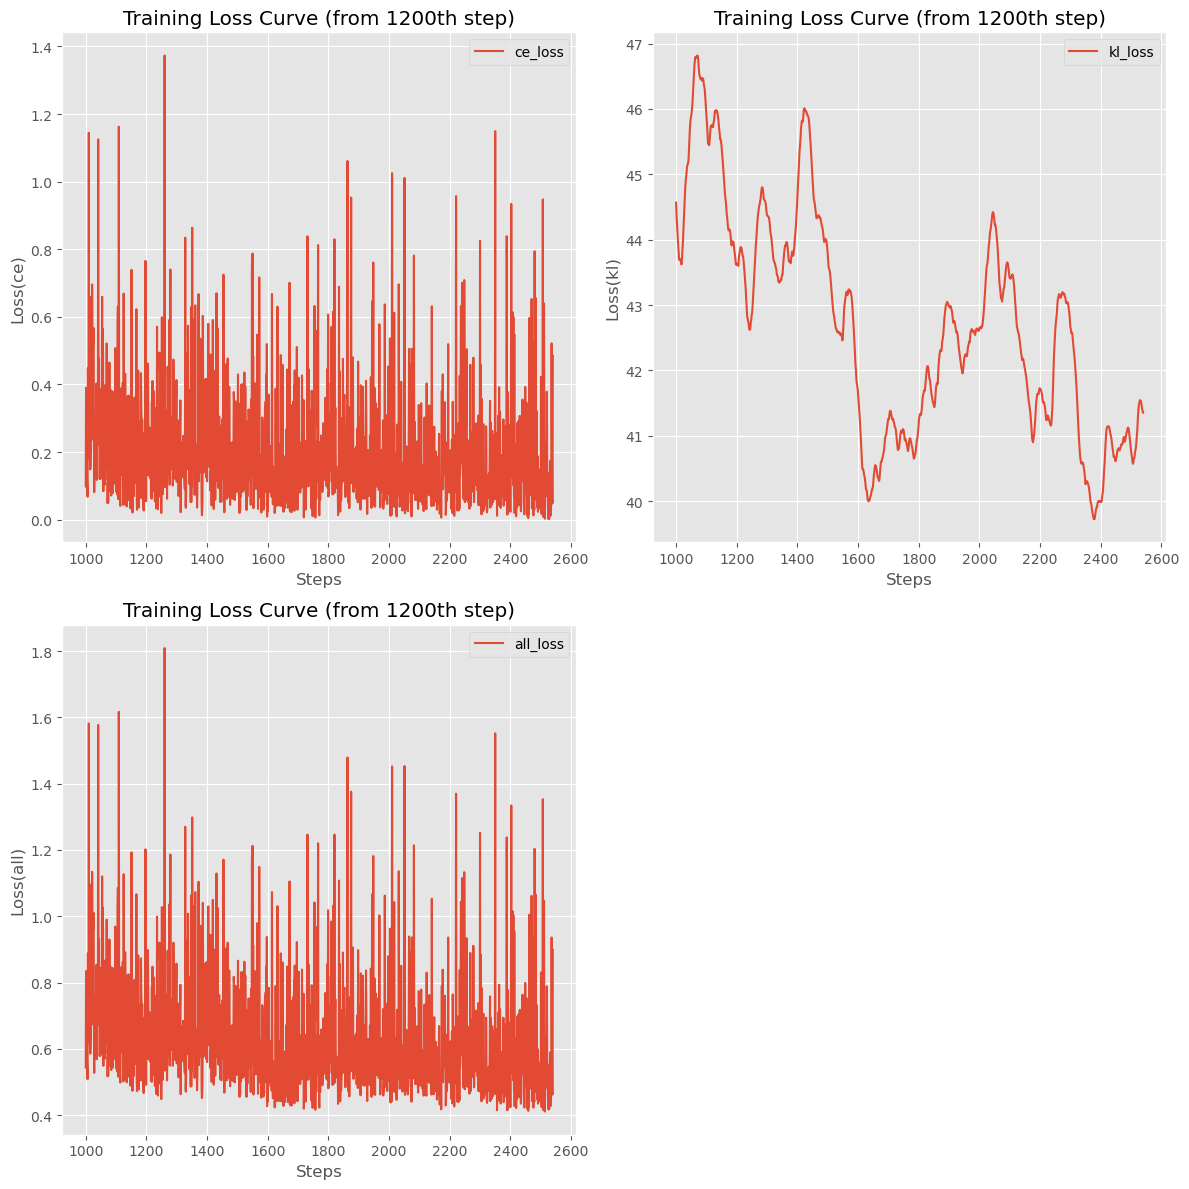

In [21]:
start_step = 1000
steps = range(start_step, start_step + len(ce_losses[start_step:]))
ce_losses_from_1200 = ce_losses[start_step:]
kl_losses_from_1200 = kl_losses[start_step:]
losses_from_1200 = losses[start_step:]

plt.style.use('ggplot')
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.plot(steps, ce_losses_from_1200, label='ce_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(ce)')
plt.legend()
plt.title('Training Loss Curve (from 1200th step)')

plt.subplot(2,2,2)
plt.plot(steps, kl_losses_from_1200, label='kl_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(kl)')
plt.legend()
plt.title('Training Loss Curve (from 1200th step)')

plt.subplot(2,2,3)
plt.plot(steps, losses_from_1200, label='all_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(all)')
plt.legend()
plt.title('Training Loss Curve (from 1200th step)')

plt.tight_layout()
plt.show()

## 4. Test Model

### 4.1 Test on seen data

In [22]:
nruntest = 32
train_filtered_seen, test_filtered_seen = getSets(filteredClass = 5, removeFiltered = False)
test_loader_seen = DataLoader(test_filtered_seen, batch_size=len(test_filtered_seen))
imgs, labels = next(iter(test_loader_seen))
imgs, labels = imgs.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    test_result_samples_seen = torch.zeros(nruntest, len(test_filtered_seen), 10)
    for i in range(nruntest):
        test_result_samples_seen[i] = F.softmax(model(imgs), dim=1)
    acrossSampleMean_seen = torch.mean(test_result_samples_seen, dim=(0,1))
    acrossSamplestd_seen = torch.std(test_result_samples_seen, dim=(0,1))

### 4.2 Test on unseen data

In [23]:
nruntest = 32
train_filtered_unseen, test_filtered_unseen = getSets(filteredClass = 4, removeFiltered = False)
test_loader_unseen = DataLoader(test_filtered_unseen, batch_size=len(test_filtered_unseen))
imgs, labels = next(iter(test_loader_unseen))
imgs, labels = imgs.to(device), labels.to(device)

with torch.no_grad():
    test_result_samples_unseen = torch.zeros(nruntest, len(test_filtered_unseen), 10)
    for i in range(nruntest):
        test_result_samples_unseen[i] = F.softmax(model(imgs), dim=1)
    acrossSampleMean_unseen = torch.mean(test_result_samples_unseen, dim=(0,1))
    acrossSamplestd_unseen = torch.std(test_result_samples_unseen, dim=(0,1))

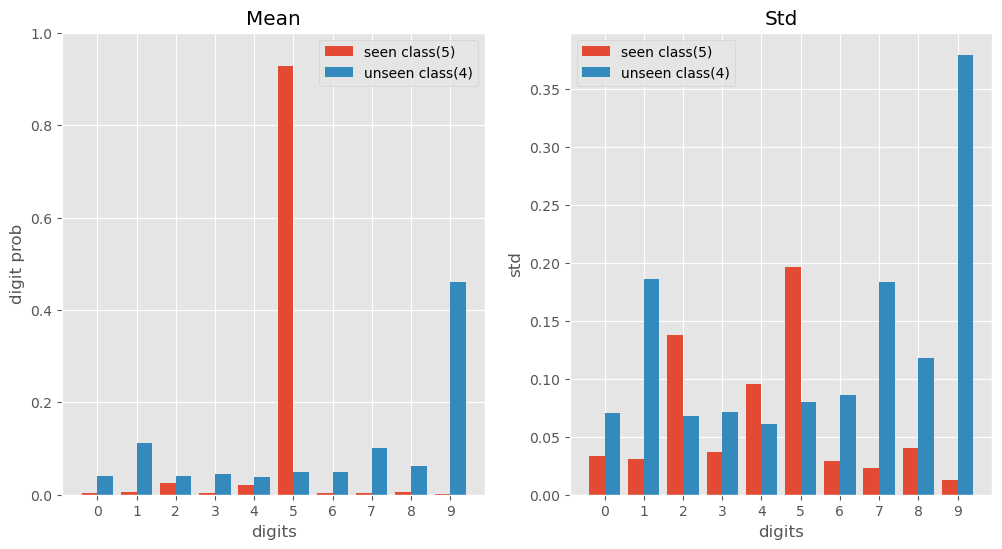

In [24]:

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Mean')
bar_width = 0.4
bar_positions = np.arange(10)
plt.bar(bar_positions - bar_width/2, acrossSampleMean_seen.numpy(), width=bar_width, label='seen class(5)')
plt.bar(bar_positions + bar_width/2, acrossSampleMean_unseen.numpy(), width=bar_width, label='unseen class(4)')
plt.xlabel('digits')
plt.ylabel('digit prob')
plt.ylim([0, 1])
plt.xticks(np.arange(10))
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Std')
plt.bar(bar_positions - bar_width/2, acrossSamplestd_seen.numpy(), width=bar_width, label='seen class(5)')
plt.bar(bar_positions + bar_width/2, acrossSamplestd_unseen.numpy(), width=bar_width, label='unseen class(4)')
plt.xlabel('digits')
plt.ylabel('std')
plt.xticks(np.arange(10))
plt.legend()
plt.savefig(os.path.join(result_dir, 'OOD(4 filtered) result.png'))